In [1]:
import os
import json
import cv2
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

HOME = os.getcwd()
os.chdir(HOME)

# Dataset

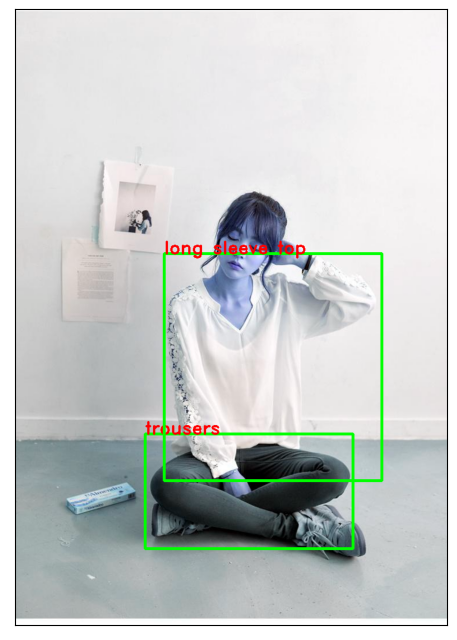

In [2]:
os.chdir('./data/')

with open('./annos/000242.json') as f:
    data = json.load(f)

image = cv2.imread('./images/000242.jpg')
for key in data.keys():
    x1, y1 = data[key]['bounding_box'][0], data[key]['bounding_box'][1]
    x2, y2 = data[key]['bounding_box'][2], data[key]['bounding_box'][3]
    image = cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 3)
    image = cv2.putText(image,
                        data[key]['category_name'],
                        org = (x1, y1), 
                        fontFace = cv2.FONT_HERSHEY_DUPLEX, 
                        fontScale = 1, 
                        color = (255, 0, 0), 
                        thickness = 2)

plt.figure(figsize=(8, 8))
plt.xticks([])
plt.yticks([])
plt.imshow(image)
plt.show()

In [3]:
datalist = []
for ann in os.listdir('./annos'):
    with open(os.path.join('./annos/', ann)) as f:
        data = json.load(f)
    for key in data.keys():
        data[key]['id'] = ann
        datalist.append(data[key])

df = pd.DataFrame(datalist, columns=['id', 'category_id', 'category_name', 'bounding_box'])

temp = pd.read_csv('../full-shot-dataset.csv', usecols=['id', 'height', 'width'])

df['id'] = df['id'].apply(lambda x: x.split('.')[0])
temp['id'] = temp['id'].apply(lambda x: x.split('.')[0])

df = df.merge(temp, on='id')

In [4]:
df['Xmin'] = df['bounding_box'].apply(lambda x: x[0])  # X_min of bounding box
df['Ymin'] = df['bounding_box'].apply(lambda x: x[1])  # Y_min of bounding box
df['Xmax'] = df['bounding_box'].apply(lambda x: x[2])  # X_max of bounding box
df['Ymax'] = df['bounding_box'].apply(lambda x: x[3])  # Y_max of bounding box

df['height_temp'] = df['Ymax']-df['Ymin']        # height not normalized
df['width_temp'] = df['Xmax']-df['Xmin']         # width not normalized
df['center x'] = df['Xmin']+df['width_temp']/2   # X_center
df['center y'] = df['Ymin']+df['height_temp']/2  # Y_center

# normalizing values
df['center x'] = df['center x']/df['width']    # Normalized X_center
df['center y'] = df['center y']/df['height']   # Normalized Y_center
df['height'] = df['height_temp']/df['height']  # normalized height
df['width'] = df['width_temp']/df['width']     # normalized width
df['category_id'] = df['category_id']-1

# new dataframe in same order as required in YOLO
final_df = df[['id', 'category_id', 'center x', 'center y', 'width', 'height']]

In [ ]:
final_df.head()

In [5]:
for value in final_df.groupby('id'):
    path='./labels/'+value[0]+'.txt'
    value[1].drop('id', inplace=True, axis=1)
    value[1].to_csv(path, header=False, index=False, sep=' ')

In [11]:
# Read images and labels
images = [os.path.join('images', x) for x in os.listdir('images')]
labels = [os.path.join('labels', x) for x in os.listdir('labels')]

images.sort()
labels.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size = 0.2, random_state = 12)
val_images, test_images, val_labels, test_labels = train_test_split(val_images, val_labels, test_size = 0.5, random_state = 12)

In [ ]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    if not os.path.exists(destination_folder):
        os.mkdir(destination_folder)
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_labels, 'labels/train/')
move_files_to_folder(val_labels, 'labels/val/')
move_files_to_folder(test_labels, 'labels/test/')

# Install YOLOv8

In [13]:
!pip install ultralytics

from IPython import display
display.clear_output()

!yolo checks

Ultralytics YOLOv8.0.92  Python-3.8.0 torch-2.0.0+cpu CPU
Setup complete  (12 CPUs, 7.8 GB RAM, 171.7/458.8 GB disk)


In [14]:
from ultralytics import YOLO
from IPython.display import display, Image

# Training the model

In [15]:
%cd {HOME}

# Loading a pretrained model
model = YOLO('yolov8n.pt')

# Use the model
model.train(data=f'{HOME}/data.yaml', epochs=1)

c:\Users\MSI 1\Desktop\Fashion


100%|██████████| 6.23M/6.23M [00:00<00:00, 9.05MB/s]
Ultralytics YOLOv8.0.92  Python-3.8.0 torch-2.0.0+cpu CPU
yolo\engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=c:\Users\MSI 1\Desktop\Fashion/data.yaml, epochs=1, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False,

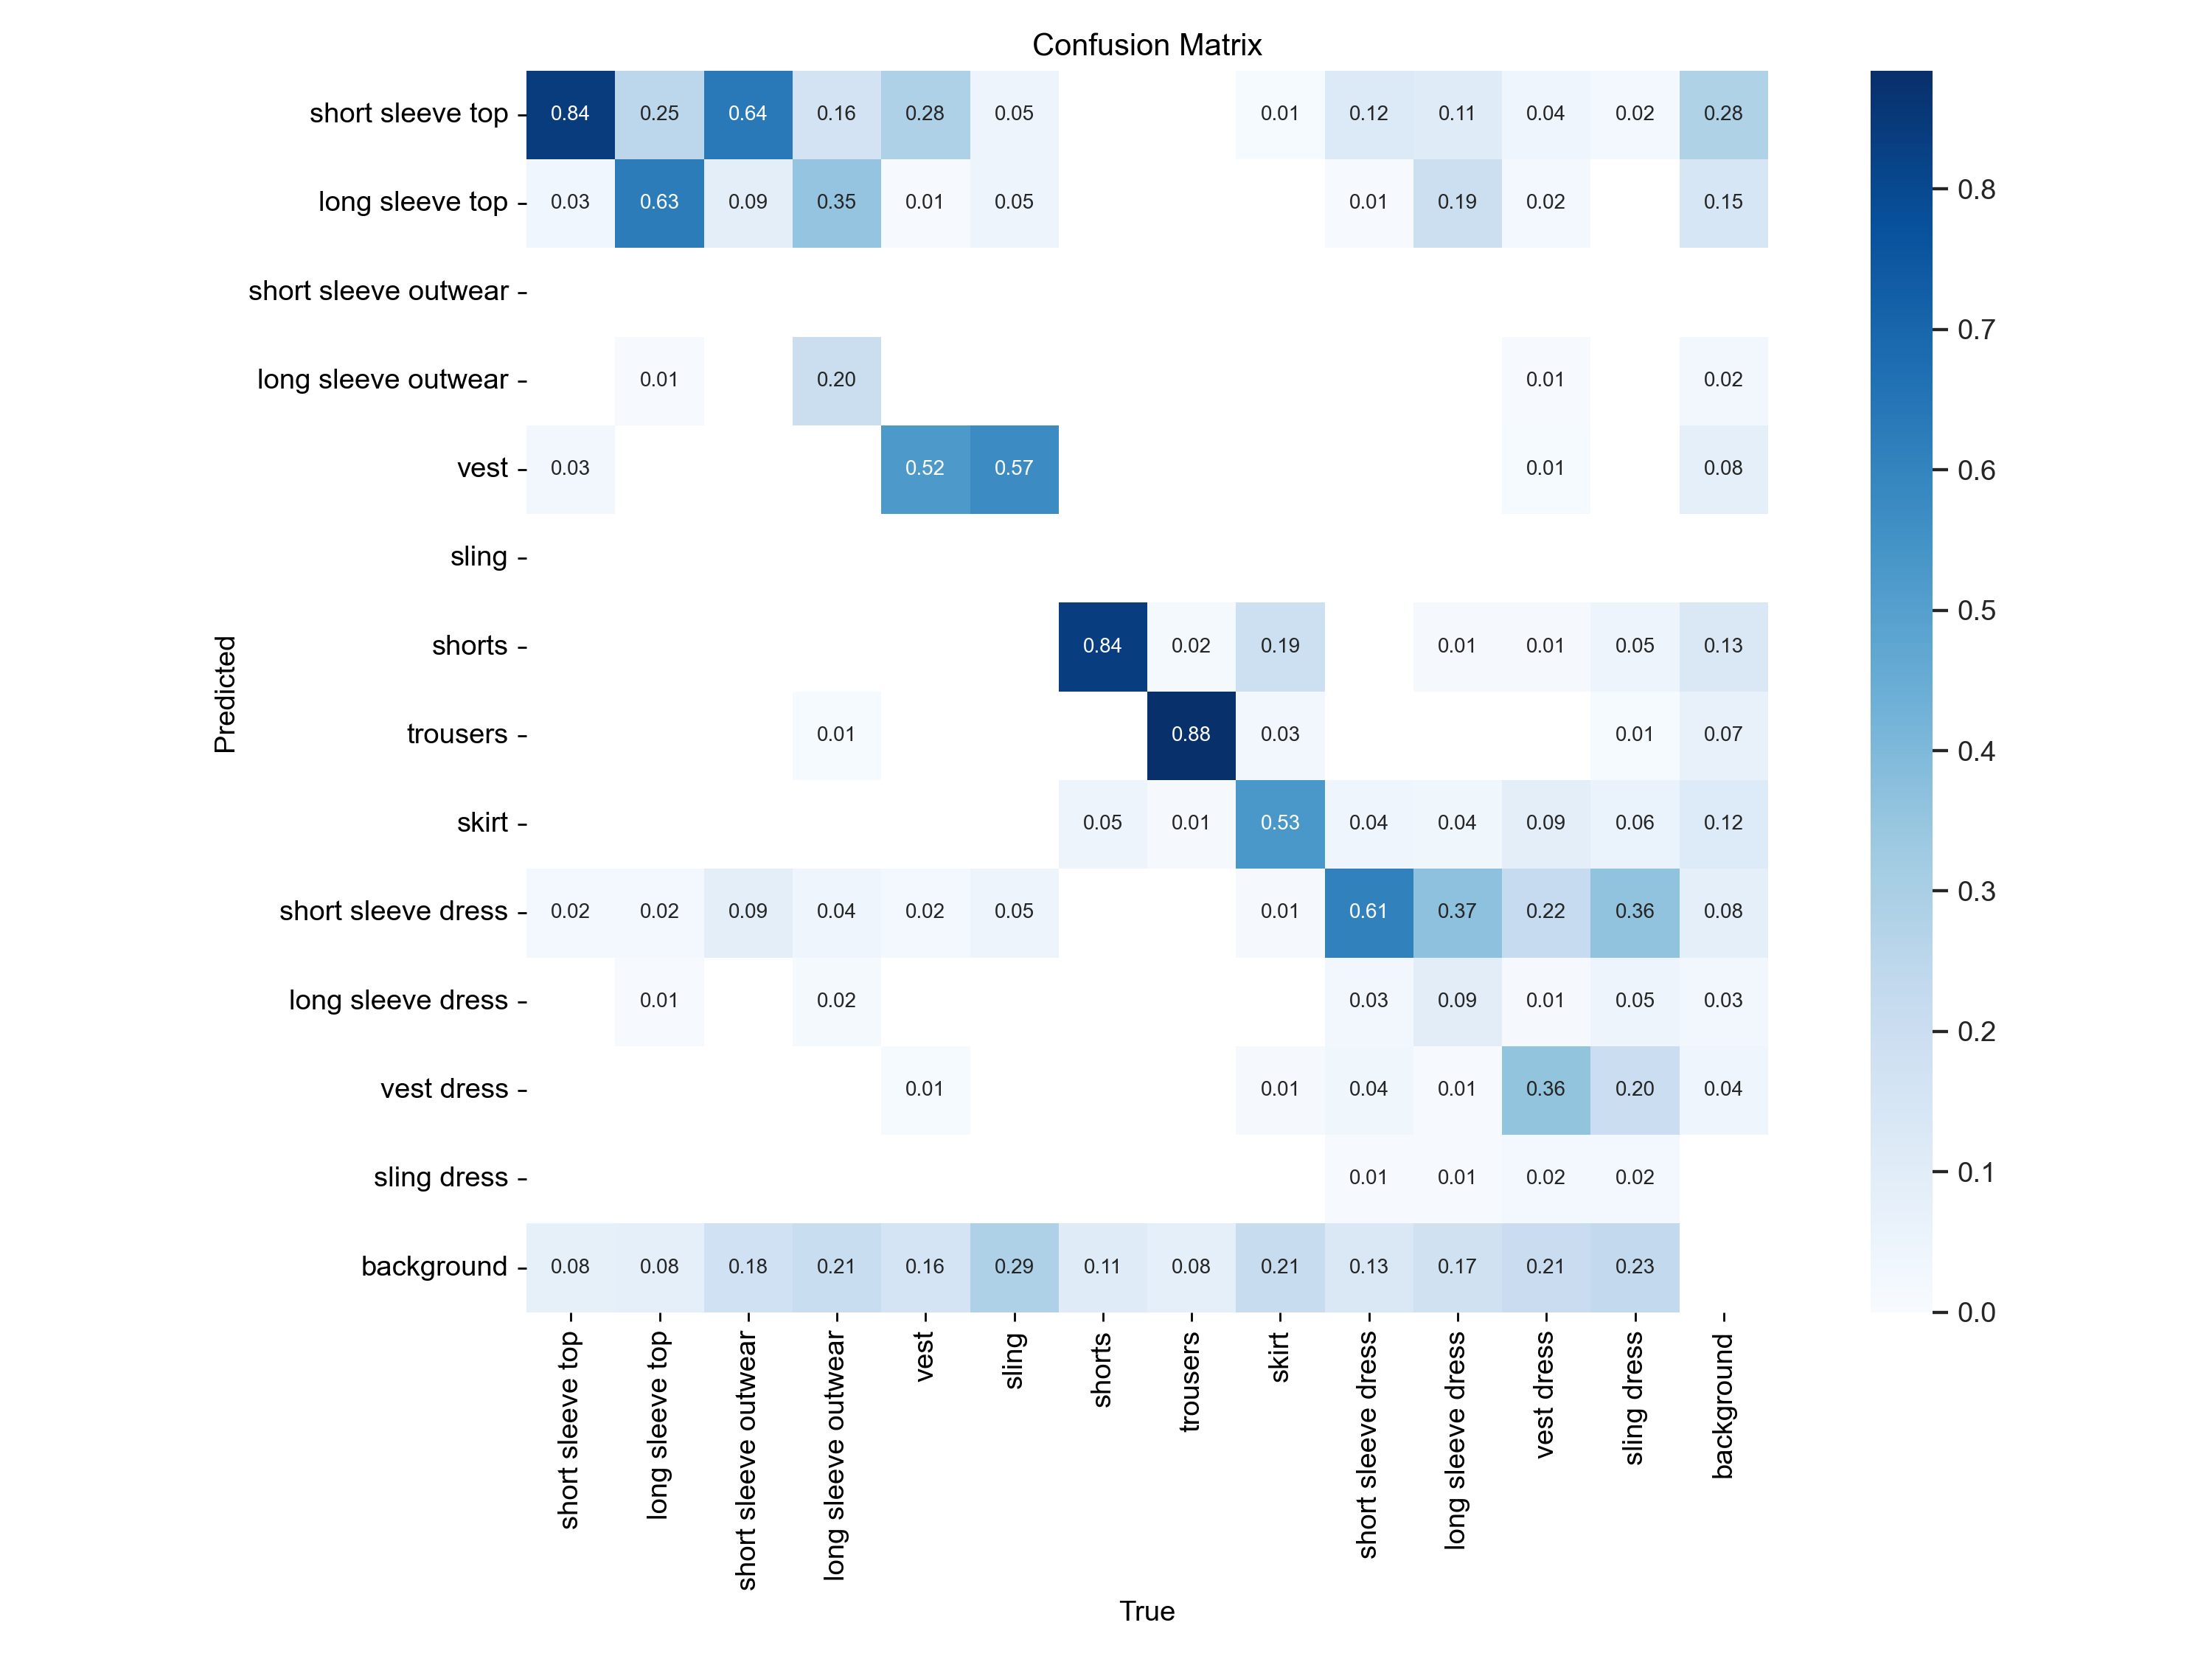

In [22]:
Image(filename=f'./runs/detect/train/confusion_matrix.png', width=1250)

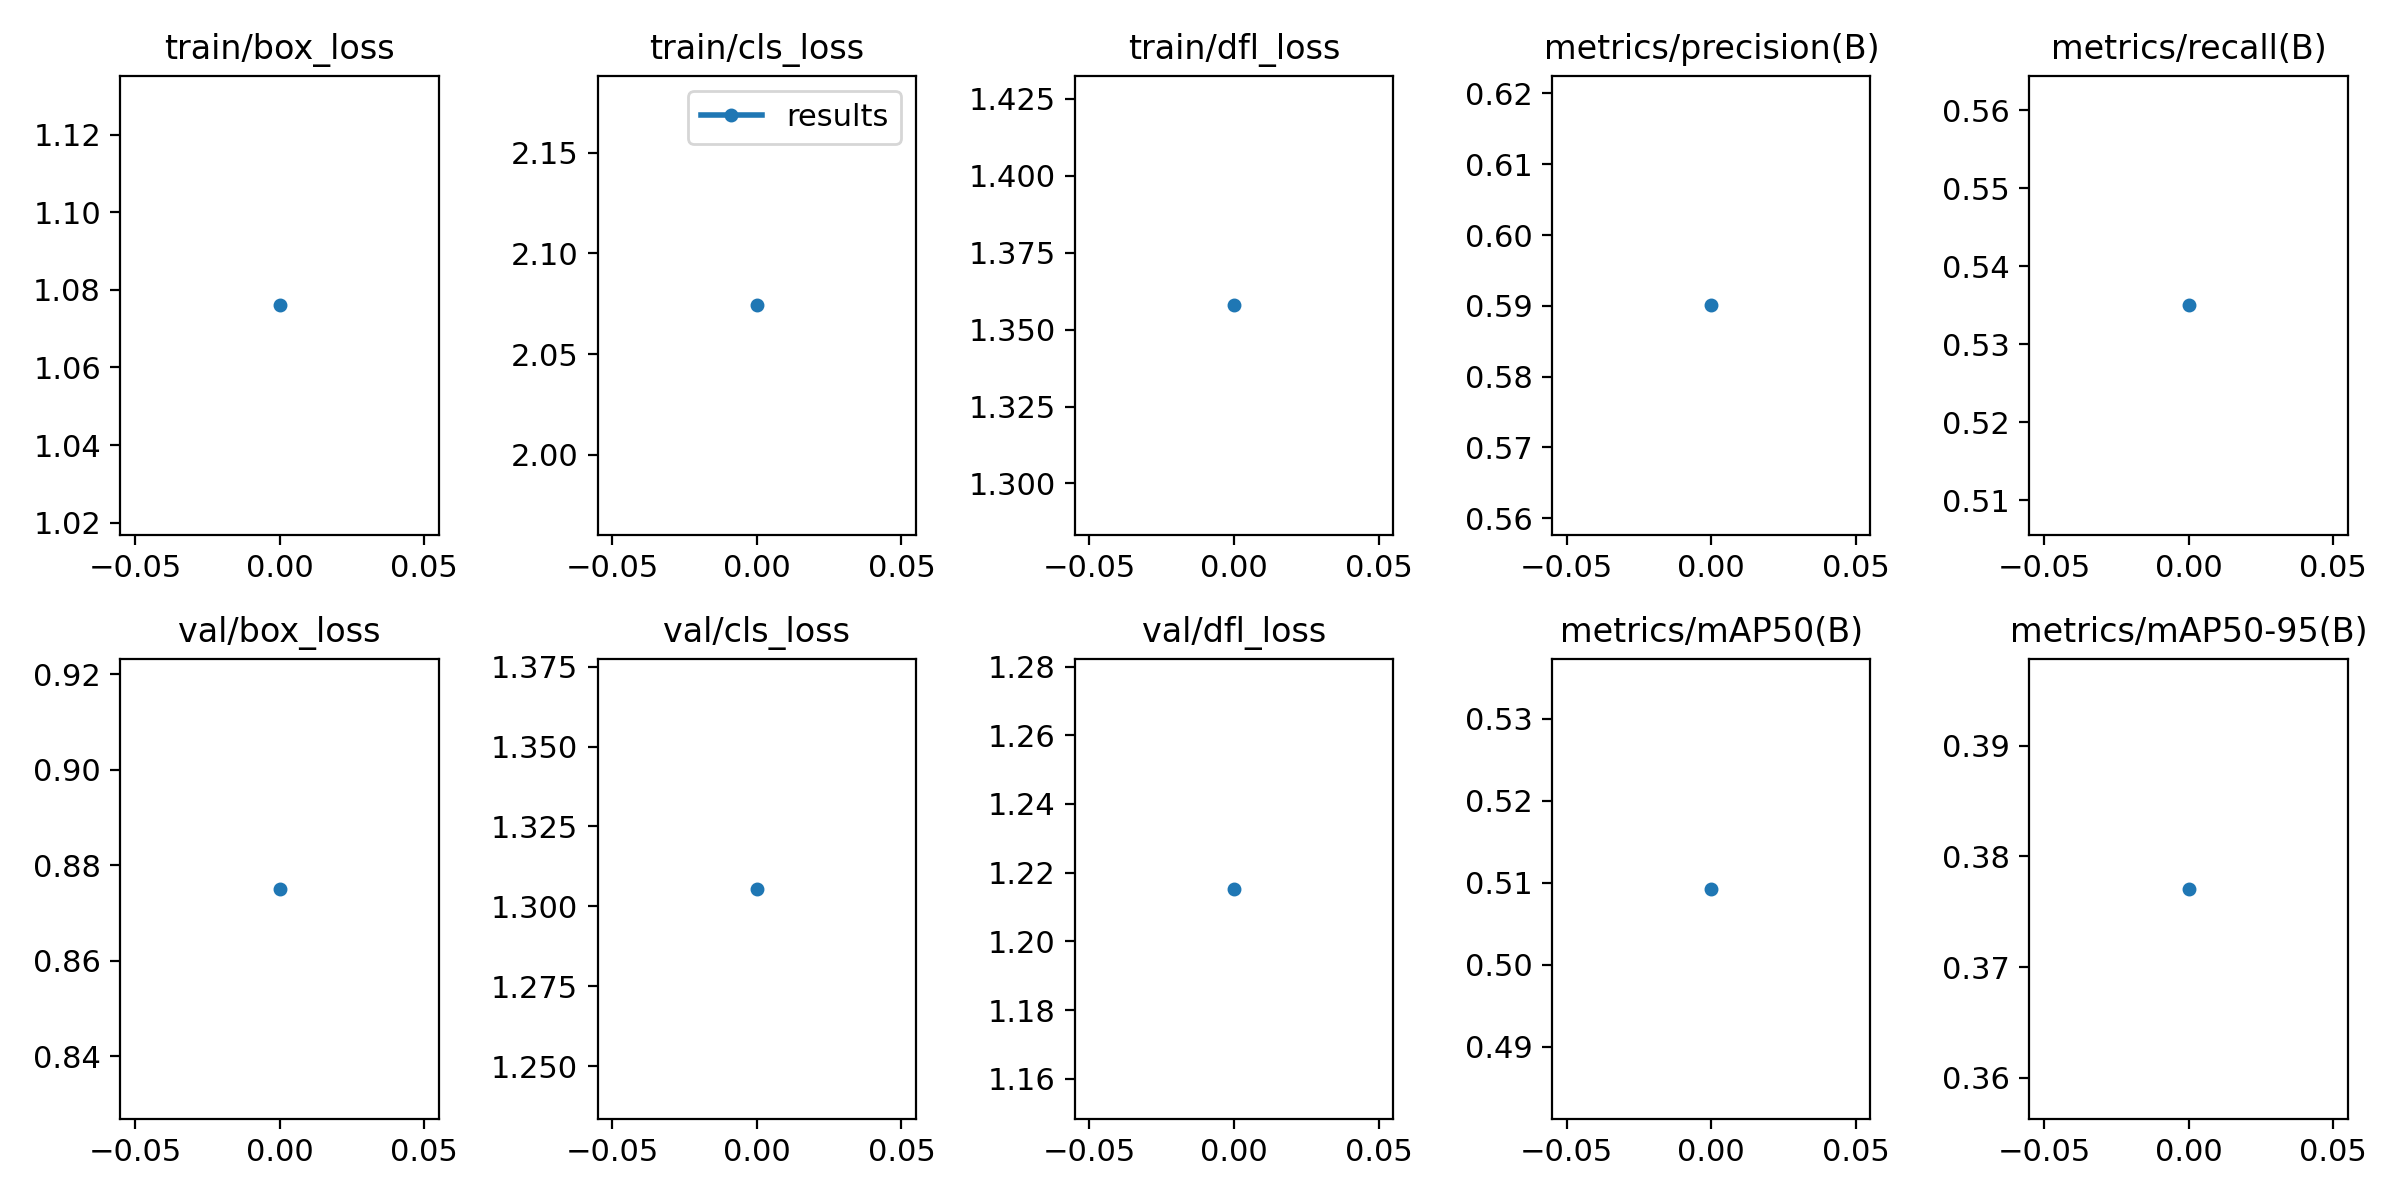

In [21]:
Image(filename=f'./runs/detect/train/results.png', width=1000)

In [ ]:
model.val(data=f'{HOME}/data.yml', )